In [1]:
import os, sys
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import numpy as np

from models import ResNet as resnet_cifar
import pandas as pd
import argparse
import csv
from torch.optim.lr_scheduler import MultiStepLR
from dataLoader import DataLoader

from PIL import Image, ImageDraw

from sklearn.metrics import confusion_matrix, classification_report    # 生成混淆矩阵函数
import matplotlib.pyplot as plt    # 绘图库

print('Init Finished!')

Init Finished!


In [2]:
args_depth = 20
num_classes = 10
args_dataset = 'cifar-10'
args_batch_size = 512

In [3]:
# Data Loader
loader = DataLoader(args_dataset,batch_size=args_batch_size)
dataloaders,dataset_sizes = loader.load_data()

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def load_model(model_path):
    model = resnet_cifar(depth=args_depth, num_classes=num_classes)
    model = model.cuda()
    model = torch.nn.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    print('Successfully Load Model: ', os.path.basename(model_path))
    return model

In [5]:
def printF(i, total=100):
    i = int( i / total * 100) + 1
    total = 100
    k = i + 1
    sys.stdout.write('\r'+'[%s%%]'%(i+1))
    sys.stdout.flush()
        
def get_weights(model):
    return model.module.lmask.get_channel_mask()
#     return model.module.lmask.mask

In [40]:

def predict_model(PATH, title,class_index):
    use_gpu = True
    epoch = 1
    phase = 'val'
    running_corrects = 0.0
    data_len = len(dataloaders[phase])
    # print(data_len)
    true_labels = []
    model_preds = []
    model.train(False)
    for idx,data in enumerate(dataloaders[phase]):
        printF(idx, data_len)
        inputs,labels = data
        if labels[0] == class_index:
            if use_gpu:
                inputs = Variable(inputs.cuda())
                labels = Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            #forward
            outputs, reg = model(inputs, labels, epoch)
            _, preds = torch.max(outputs.data, 1)
            # _,top5_preds = torch.topk(outputs.data,k=5,dim=1)
            # print ('group loss:',group_loss[0])
            y = labels.data
            batch_size = labels.data.shape[0]
            # print(y.resize_(batch_size,1))
            running_corrects += torch.sum(preds == y)
            # top5_corrects += torch.sum(top5_preds == y.resize_(batch_size,1))
            true_labels.extend(y.cpu().numpy())
            model_preds.extend(preds.cpu().numpy())
    epoch_acc = float(running_corrects) /len(true_labels)
    print('%s top1 Acc:%.4f'%(phase,epoch_acc))
    
    #Draw weights
    weights = get_weights(model)
    weights = weights.cpu().detach().numpy()
    weights = np.transpose(weights)
    print(weights.shape)
    fig = plt.figure(figsize=(20,6))
    ax = fig.add_subplot(111)
    im = ax.imshow(weights,cmap=plt.cm.jet)
    plt.colorbar(im,orientation='vertical')
    plt.title(title)
    plt.show()
    return true_labels, model_preds,weights

In [27]:
labels_name = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
def visulizeFeature(weights,title):
    print(len(features_blobs))
    activation_val = []
    feature = np.mean(np.concatenate(features_blobs,0),axis=0)
    print(feature.shape)
    channel = feature.shape[0]
    activation_val = np.mean(np.reshape(feature,(channel,-1)),axis=-1)
#     activation_val = list(enumerate(activation_val))
#     activation_val = sorted(activation_val,key=lambda item:item[1],reverse=True)
    print(activation_val.shape)
    group_activate = []
    for i in range(10):
        class_filter = np.reshape(weights[i],(channel))*activation_val
        selected_channel = np.mean(class_filter,axis=0)
        group_activate.append(selected_channel)
    plt.figure(figsize=(6,6))
    plt.bar(range(len(group_activate)),group_activate,tick_label=list(labels_name))
    plt.title(title)
    plt.show()

Successfully Load Model:  saved_model.pt
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[100%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[101%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[101%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[101%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[101%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[101%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[101%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[101%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[101%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>[101%]
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>

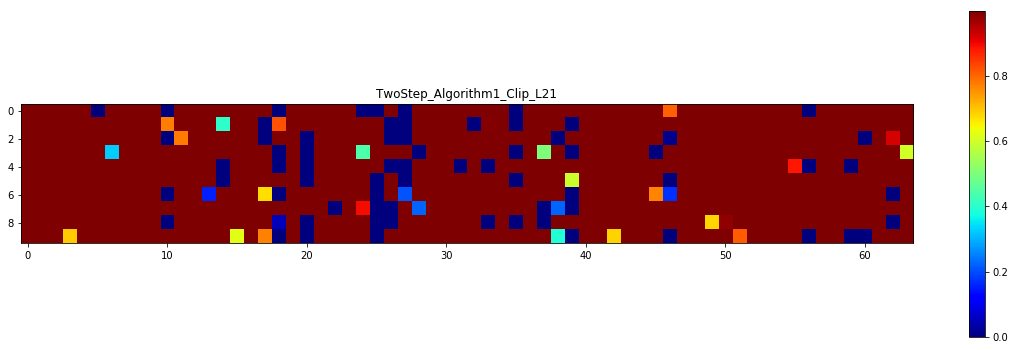

In [45]:
PATH ='/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask_baseline/TwoStep_Algorithm1_Clip_L21'
# PATH = '/data/ouyangzhihao/Exp/ICNN/LearnableMask/tb_dir/learnable_mask/Relu_ResNet_LMask'
title = PATH.split('/')[-1]
model_path = os.path.join(PATH, 'saved_model.pt')

model = load_model(model_path)
# 该数组记录中间层结果
features_blobs = []
# 该函数由register_forward_hook调用，类似于event handler，当resnet前向传播时记录所需中间层结果
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())
    # 需要输出的中间层名称，名称为resnet_for_vis的__init__函数中声明的。
finalconv_name = 'layer3'
# model.layer3.register_forward_hook(hook_feature)
model._modules.get('module').layer3.register_forward_hook(hook_feature)

class_index = 2
true_labels, model_preds,weights = predict_model(model_path, title,class_index)





1000
(64, 8, 8)
(64,)


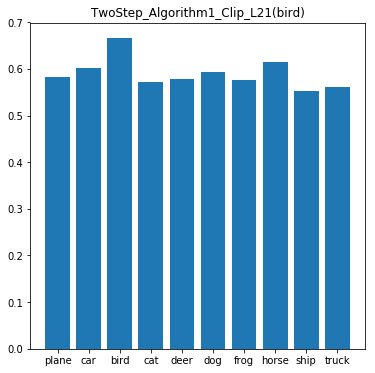

In [46]:
title = PATH.split('/')[-1]
title = title + '(' + labels_name[class_index] + ')'
visulizeFeature(weights,title)